In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numba
from numba import cuda
import time
import math
import sys

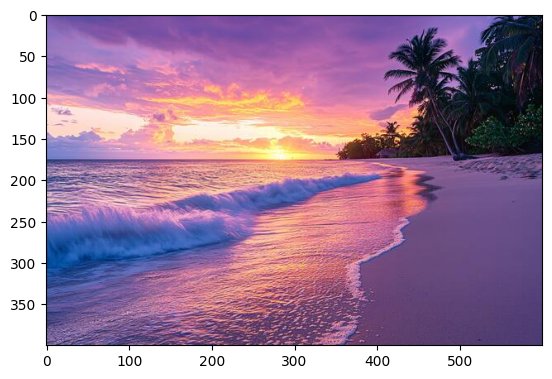

In [2]:
img = plt.imread('./image.jpg')
plt.imshow(img)
plt.show()

In [3]:
height = img.shape[0]
width = img.shape[1]
depth = img.shape[2]
print(img.shape)
print(np.shape(img))

(400, 600, 3)
(400, 600, 3)


In [4]:
# def gaussian_blur_filter_generate(sigma=1, size=7):
#     x = y = np.arange(-np.floor(size/2), np.floor(size/2)+1, 1)
#     xv, yv = np.meshgrid(x, y)
#     G_x_y = (1 / (2 * np.pi * sigma**2)) * np.exp( -(xv**2 + yv**2) / (2*sigma**2) )
#     return np.round(G_x_y, 2)/np.sum(G_x_y)

# def convolution2d(original_image, filter):
#     kernel = np.flipud(np.fliplr(filter))
#     output = np.zeros_like(original_image)
#     image_padded = np.pad(original_image, 
#                           pad_width=(
#                               (kernel.shape[0]//2, kernel.shape[0]//2),
#                               (kernel.shape[0]//2, kernel.shape[0]//2), 
#                               (0,0)), mode= "constant", constant_values=0)

#     for dep in range(original_image.shape[2]):
#         for row in range(original_image.shape[0]):
#             for col in range(original_image.shape[1]):
#                 k = kernel.shape[0]
#                 output[row, col, dep] = np.sum(kernel * image_padded[row:row+k, col:col+k, dep])
#     return output

# filter = gaussian_blur_filter_generate(sigma=3)
# output = convolution2d(img, filter)
# plt.imshow(output)
# plt.show()

In [5]:
img.shape

(400, 600, 3)

In [6]:
def gaussian_blur_func(std=1, size=7):
    x = y = np.arange(-np.floor(size/2), np.floor(size/2)+1, 1)
    xv, yv = np.meshgrid(x, y)
    G_x_y = (1 / (2 * np.pi * std**2)) * np.exp( -(xv**2 + yv**2) / (2*std**2) )
    return G_x_y / np.sum(G_x_y)

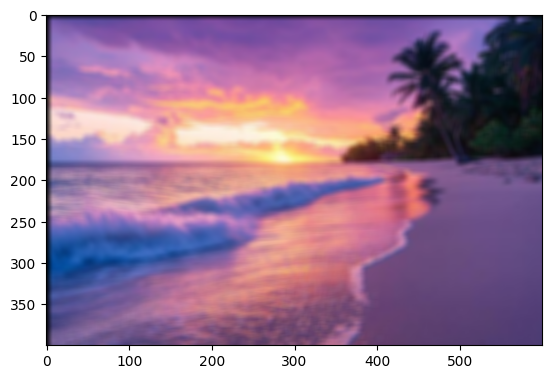

In [7]:
def convolution2d(original_image, filter):
    @cuda.jit
    def convolution2d_gpu(kernel_ary, image_padded_ary, output_ary):
        out_row = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y
        out_col = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x

        kernel_ary_height, kernel_ary_width = kernel_ary.shape
        half_kernel_ary_height, half_kernel_ary_width = kernel_ary_height//2, kernel_ary_width//2

        if out_row < output_ary.shape[0] and out_col < output_ary.shape[1]:
            for dep in range(output_ary.shape[2]):
                conv2d_sum = 0
                for i in range(kernel_ary_height):
                    for j in range(kernel_ary_width):
                        input_row = out_row - half_kernel_ary_height + i
                        input_col = out_col - half_kernel_ary_width + j
                        conv2d_sum += image_padded_ary[input_row, input_col, dep] * kernel_ary[i, j]
                output_ary[out_row, out_col, dep] = conv2d_sum


    kernel = np.ascontiguousarray(np.flipud(np.fliplr(filter)))
    image_padded = np.pad(original_image, 
                          pad_width=(
                              (kernel.shape[0]//2, kernel.shape[0]//2),
                              (kernel.shape[1]//2, kernel.shape[1]//2), 
                              (0,0)), mode= "constant", constant_values=0)
    kernel_ary = cuda.to_device(kernel)
    image_padded_ary = cuda.to_device(image_padded)
    output_ary = cuda.device_array(original_image.shape)

    h, w, _ = output_ary.shape

    threadsperblock = (32, 32)
    blockspergrid_x = math.ceil(w / threadsperblock[0])
    blockspergrid_y = math.ceil(h / threadsperblock[1])
    blockspergrid = (blockspergrid_x, blockspergrid_y)
    
    convolution2d_gpu[blockspergrid, threadsperblock](kernel_ary, image_padded_ary, output_ary)

    output = output_ary.copy_to_host()
    return output.astype("uint8")

filter = gaussian_blur_func(std=4, size=9)
output = convolution2d(img, filter)
plt.imshow(output)
plt.show()

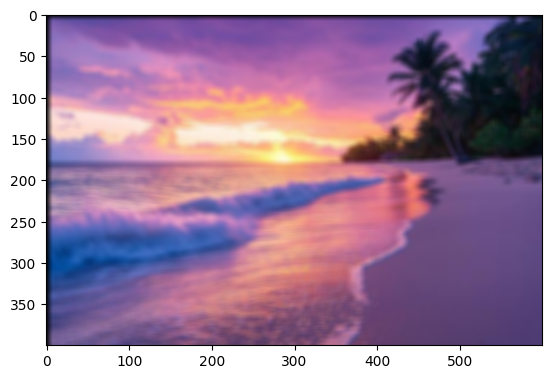

In [47]:
TPB = 32
CHANNELS = 3
STD = 4
FILTER_SIZE = 9

def convolution2d_shared_memory(original_image, filter, tpb):
    @cuda.jit
    def convolution2d_gpu(kernel_ary, image_padded_ary, output_ary):
        out_row = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y
        out_col = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x

        kernel_ary_height, kernel_ary_width = kernel_ary.shape
        half_kernel_ary_height, half_kernel_ary_width = kernel_ary_height//2, kernel_ary_width//2

        s_image_padded_ary = cuda.shared.array(shape=(TPB, TPB, CHANNELS), dtype=numba.uint8)
        s_kernel_ary = cuda.shared.array(shape=(FILTER_SIZE, FILTER_SIZE), dtype=numba.float32)

        ty = cuda.threadIdx.y
        tx = cuda.threadIdx.x

        if ty < kernel_ary_height and tx < kernel_ary_width:
            s_kernel_ary[ty, tx] = kernel_ary[ty, tx]
        cuda.syncthreads()

        if out_row < output_ary.shape[0] and out_col < output_ary.shape[1]:
            for dep in range(output_ary.shape[2]):
                conv2d_sum = numba.float32(0.0)
                for i in range(kernel_ary_height):
                    for j in range(kernel_ary_width):
                        # s_image_padded_ary[ty, tx, dep] = 0
                        input_row = out_row - half_kernel_ary_height + i
                        input_col = out_col - half_kernel_ary_width + j
                        s_image_padded_ary[ty, tx, dep] = image_padded_ary[input_row, input_col, dep]
                        cuda.syncthreads()

                        conv2d_sum += s_image_padded_ary[ty, tx, dep] * s_kernel_ary[i, j]
                output_ary[out_row, out_col, dep] = conv2d_sum


    kernel = np.ascontiguousarray(np.flipud(np.fliplr(filter)))
    image_padded = np.pad(original_image, 
                          pad_width=(
                              (kernel.shape[0]//2, kernel.shape[0]//2),
                              (kernel.shape[1]//2, kernel.shape[1]//2), 
                              (0,0)), mode= "constant", constant_values=0)
    kernel_ary = cuda.to_device(kernel.astype(np.float32))
    image_padded_ary = cuda.to_device(image_padded)
    output_ary = cuda.device_array(original_image.shape, dtype=np.float32)

    h, w, _ = output_ary.shape

    threadsperblock = (tpb, tpb)
    blockspergrid_x = math.ceil(w / threadsperblock[0])
    blockspergrid_y = math.ceil(h / threadsperblock[1])
    blockspergrid = (blockspergrid_x, blockspergrid_y)
    
    convolution2d_gpu[blockspergrid, threadsperblock](kernel_ary, image_padded_ary, output_ary)

    output = output_ary.copy_to_host()
    return np.clip(output, 0, 255).astype("uint8")

filter = gaussian_blur_func(std=STD, size=FILTER_SIZE)
output = convolution2d_shared_memory(img, filter, TPB)
plt.imshow(output)
plt.show()

C:\Users\admin\AppData\Local\Temp\ipykernel_47808\2968113940.py:60: RuntimeWarning: invalid value encountered in cast
  return np.clip(output, 0, 255).astype("uint8")
C:\Users\admin\AppData\Local\Temp\ipykernel_47808\2968113940.py:60: RuntimeWarning: invalid value encountered in cast
  return np.clip(output, 0, 255).astype("uint8")
C:\Users\admin\AppData\Local\Temp\ipykernel_47808\2968113940.py:60: RuntimeWarning: invalid value encountered in cast
  return np.clip(output, 0, 255).astype("uint8")
C:\Users\admin\AppData\Local\Temp\ipykernel_47808\2968113940.py:60: RuntimeWarning: invalid value encountered in cast
  return np.clip(output, 0, 255).astype("uint8")
C:\Users\admin\AppData\Local\Temp\ipykernel_47808\2968113940.py:60: RuntimeWarning: invalid value encountered in cast
  return np.clip(output, 0, 255).astype("uint8")
C:\Users\admin\AppData\Local\Temp\ipykernel_47808\2968113940.py:60: RuntimeWarning: invalid value encountered in cast
  return np.clip(output, 0, 255).astype("uint8"

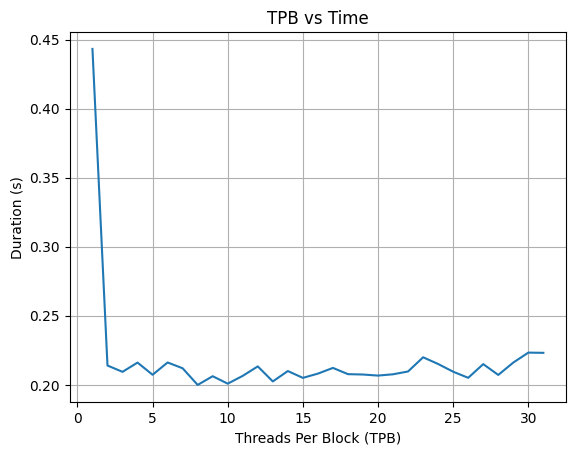

In [54]:
tpbs = [int(i) for i in np.arange(1, 32, 1, dtype=int)]
filter = gaussian_blur_func(std=STD, size=FILTER_SIZE)
duration = []
for tpb in tpbs:
    start = time.time()
    output = convolution2d_shared_memory(img, filter, tpb=tpb)
    runtime = time.time()-start
    duration.append(runtime)

plt.plot(tpbs, duration)
plt.xlabel('Threads Per Block (TPB)')
plt.ylabel('Duration (s)')
plt.title('TPB vs Time')
plt.grid(True)
plt.show()